# T<sub>2</sub> Ramsey Characterization

The purpose of the $T_2$Ramsey experiment is to determine two of the qubit's properties: *Ramsey* or *detuning frequency* and $T_2^\ast$. The rough frequency of the qubit was already determined previously. The control pulses are based on this frequency. 

In this experiment, we would like to get a more precise estimate of the qubit's frequency. The difference between the frequency used for the control rotation pulses, and the precise frequency is called the *detuning frequency*. This part of the experiment is called a *Ramsey Experiment*. $T_2^\ast$ represents the rate of decay toward a mixed state, when the qubit is initialized to the $\left|1\right\rangle$ state.

Since the detuning frequency is relatively small, we add a phase gate to the circuit to enable better measurement. The actual frequency measured is the sum of the detuning frequency and the user induced *oscillation frequency* (`osc_freq` parameter).

In [1]:
import qiskit
from qiskit_experiments.library import T2Ramsey

The circuit used for the experiment comprises the following:

    1. Hadamard gate
    2. delay
    3. RZ gate that rotates the qubit in the x-y plane 
    4. Hadamard gate
    5. measurement

During the delay time, we expect the qubit to precess about the z-axis. If the p gate and the precession offset each other perfectly, then the qubit will arrive at the $\left|0\right\rangle$ state (after the second Hadamard gate). By varying the extension of the delays, we get a series of oscillations of the qubit state between the $\left|0\right\rangle$ and $\left|1\right\rangle$ states. We can draw the graph of the resulting function, and can analytically extract the desired values.

In [2]:
# set the computation units to microseconds
unit = "us"  # microseconds
qubit = 0
# set the desired delays
delays = list(range(1, 50, 1))

In [3]:
# Create a T2Ramsey experiment. Print the first circuit as an example
exp1 = T2Ramsey(qubit, delays, unit=unit, osc_freq=1e5)
print(exp1.circuits()[0])

     ┌───┐┌──────────────┐┌─────────────┐ ░ ┌───┐ ░ ┌─┐
q_0: ┤ H ├┤ Delay(1[us]) ├┤ Rz(200000π) ├─░─┤ H ├─░─┤M├
     └───┘└──────────────┘└─────────────┘ ░ └───┘ ░ └╥┘
c: 1/════════════════════════════════════════════════╩═
                                                     0 


We run the experiment on a simple, simulated backend, created specifically for this experiment's tutorial.

In [4]:
from qiskit_experiments.test.t2ramsey_backend import T2RamseyBackend
# FakeJob is a wrapper for the backend, to give it the form of a job
from qiskit_experiments.test.utils import FakeJob

conversion_factor = 1e-6
# The behavior of the backend is determined by the following parameters
backend = T2RamseyBackend(
    p0={
        "A": [0.5],
        "T2star": [20.0],
        "f": [0.11],
        "phi": [0.0],
        "B": [0.5],
    },
    initial_prob_plus=[0.0],
    readout0to1=[0.02],
    readout1to0=[0.02],
    conversion_factor=conversion_factor,
)

The resulting graph will have the form:
$f(t) = a^{-t/T_2*} \cdot \cos(2 \pi f t + \phi) + b$
where *t* is the delay, $T_2^\ast$ is the decay factor, and *f* is the detuning frequency.
`conversion_factor` is a scaling factor that depends on the measurement units used. It is 1E-6 here, because the unit is microseconds.

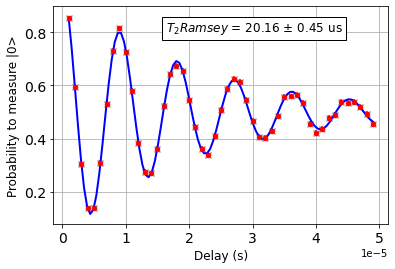

In [5]:
exp1.set_analysis_options(user_p0=None, plot=True)
expdata1 = exp1.run(backend=backend, shots=2000)
expdata1.block_for_results()  # Wait for job/analysis to finish.

# Display the figure
display(expdata1.figure(0))

In [6]:
# Print results
for result in expdata1.analysis_results():
    print(result)

DbAnalysisResultV1
- name: T2star
- value: 2.0155267105588843e-05 ± 4.4641448204770044e-07 s
- χ²: 0.7478697549594664
- quality: good
- extra: <10 items>
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: Frequency
- value: 110341.9657187354 ± 177.95715129915607 Hz
- χ²: 0.7478697549594664
- quality: good
- extra: <10 items>
- device_components: ['Q0']
- verified: False


Additional fitter result data is stored in the `result.extra` field

In [7]:
expdata1.analysis_results("T2star").extra

{'popt': array([ 4.77594767e-01,  2.01552671e-05,  1.10341966e+05, -2.60143452e-02,
         4.97723493e-01]),
 'popt_keys': None,
 'popt_err': array([6.35443088e-03, 4.46414482e-07, 1.77957151e+02, 1.43387909e-02,
        1.52390209e-03]),
 'pcov': array([[ 4.03787918e-05, -2.09772956e-09, -1.59524156e-01,
          1.84522424e-05,  7.56004234e-07],
        [-2.09772956e-09,  1.99285890e-13,  7.68765916e-06,
         -9.17472187e-10, -3.04638035e-11],
        [-1.59524156e-01,  7.68765916e-06,  3.16687477e+04,
         -1.85185229e+00, -2.56283640e-02],
        [ 1.84522424e-05, -9.17472187e-10, -1.85185229e+00,
          2.05600925e-04,  3.46212745e-06],
        [ 7.56004234e-07, -3.04638035e-11, -2.56283640e-02,
          3.46212745e-06,  2.32227759e-06]]),
 'reduced_chisq': 0.7478697549594664,
 'dof': 44,
 'x_range': (1e-06, 4.9e-05),
 'y_range': (0.1375, 0.8525),
 'circuit_unit': 'us',
 'osc_freq': 100000.0}

### Providing initial user estimates
The user can provide initial estimates for the parameters to help the analysis process. Because the curve is expected to decay toward $0.5$, the natural choice for parameters $A$ and $B$ is $0.5$. Varying the value of $\phi$ will shift the graph along the x-axis. Since this is not of interest to us, we can safely initialize $\phi$ to 0. In this experiment, `t2ramsey` and `f` are the parameters of interest. Good estimates for them are values computed in previous experiments on this qubit or a similar values computed for other qubits.

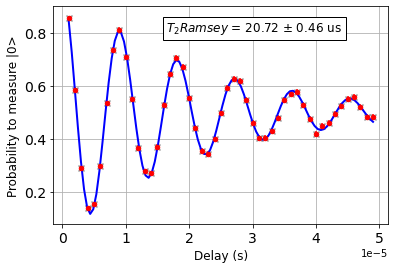

In [8]:
from qiskit_experiments.library.characterization import T2RamseyAnalysis
user_p0={
    "A": 0.5,
    "T2star": 20.0,
    "f": 0.11,
    "phi": 0,
    "B": 0.5
        }
exp_with_p0 = T2Ramsey(qubit, delays, unit=unit, osc_freq=1e5)
exp_with_p0.set_analysis_options(user_p0=user_p0, plot=True)
expdata_with_p0 = exp_with_p0.run(backend=backend, shots=2000)
expdata_with_p0.block_for_results()

# Display fit figure
display(expdata_with_p0.figure(0))

In [9]:
# Print results
for result in expdata_with_p0.analysis_results():
    print(result)

DbAnalysisResultV1
- name: T2star
- value: 2.0715452227690385e-05 ± 4.5947030975967625e-07 s
- χ²: 0.9687148408825222
- quality: good
- extra: <10 items>
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: Frequency
- value: 110066.07611868446 ± 172.10370396837413 Hz
- χ²: 0.9687148408825222
- quality: good
- extra: <10 items>
- device_components: ['Q0']
- verified: False


The units can be changed, but the output in the result is always given in seconds. The units in the backend must be adjusted accordingly.

In [10]:
from qiskit.utils import apply_prefix

unit = "ns"
delays = list(range(1000, 50000, 1000))
conversion_factor = apply_prefix(1, unit)
print(conversion_factor)

1e-09


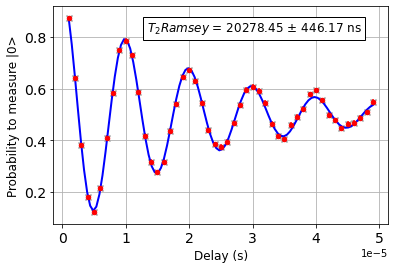

In [11]:
p0 = {
    "A": [0.5],
    "T2star": [20000],
    "f": [0.0001],
    "phi": [0.0],
    "B": [0.5],
}
backend_in_ns = T2RamseyBackend(
    p0=p0,
    initial_prob_plus=[0.0],
    readout0to1=[0.02],
    readout1to0=[0.02],
    conversion_factor=conversion_factor,
)
exp_in_ns = T2Ramsey(qubit, delays, unit=unit, osc_freq=1e5)
user_p0_ns = {
    "A": 0.5,
    "T2star": 20000.0,
    "f": 0.00011,
    "phi": 0,
    "B": 0.5
        }
exp_in_ns.set_analysis_options(user_p0=user_p0_ns, plot=True)

# Run experiment
expdata_in_ns = exp_in_ns.run(backend=backend_in_ns, shots=2000).block_for_results()

# Display Figure
display(expdata_in_ns.figure(0))

In [12]:
# Print Results
for result in expdata_in_ns.analysis_results():
    print(result)

DbAnalysisResultV1
- name: T2star
- value: 2.0278449813730705e-05 ± 4.46168813894067e-07 s
- χ²: 0.9253828449214311
- quality: good
- extra: <10 items>
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: Frequency
- value: 100324.82885018068 ± 179.6704391377334 Hz
- χ²: 0.9253828449214311
- quality: good
- extra: <10 items>
- device_components: ['Q0']
- verified: False


In [13]:
import qiskit.tools.jupyter
%qiskit_copyright